# implementation of E-NET model


https://arxiv.org/pdf/1606.02147.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import re
from PIL import Image


import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import os
import sys
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *


from tensorflow.keras.applications.resnet50 import *
from tensorflow.keras.models import *

import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Cropping2D, Conv2D
from tensorflow.keras.layers import Input, Add, Dropout, Permute, add
from tensorflow.compat.v1.layers import conv2d_transpose
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
print(tf.__version__)

2.3.0


In [3]:
print("Is there a GPU available: "),
print(tf.test.is_gpu_available())


Is there a GPU available: 
False


In [4]:
print(tf.executing_eagerly())

True


In [5]:
!wget http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamSeq01/CamSeq01.zip

--2020-08-25 17:36:19--  http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamSeq01/CamSeq01.zip
Resolving mi.eng.cam.ac.uk (mi.eng.cam.ac.uk)... 129.169.82.147
Connecting to mi.eng.cam.ac.uk (mi.eng.cam.ac.uk)|129.169.82.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94535380 (90M) [application/zip]
Saving to: ‘CamSeq01.zip’

CamSeq01.zip        100%[===================>]  90.16M  50.6MB/s    in 1.8s    

2020-08-25 17:36:22 (50.6 MB/s) - ‘CamSeq01.zip’ saved [94535380/94535380]



In [6]:
cwd = os.getcwd()
cwd

'/kaggle/working'

In [7]:
!mkdir data
!mkdir data/CamSeq01

In [8]:
!unzip CamSeq01.zip -d data/CamSeq01

Archive:  CamSeq01.zip
  inflating: data/CamSeq01/0016E5_07977_L.png  
  inflating: data/CamSeq01/0016E5_07979_L.png  
  inflating: data/CamSeq01/0016E5_07981_L.png  
  inflating: data/CamSeq01/0016E5_07983_L.png  
  inflating: data/CamSeq01/0016E5_07985_L.png  
  inflating: data/CamSeq01/0016E5_07987_L.png  
  inflating: data/CamSeq01/0016E5_07989_L.png  
  inflating: data/CamSeq01/0016E5_07991_L.png  
  inflating: data/CamSeq01/0016E5_07993_L.png  
  inflating: data/CamSeq01/0016E5_07995_L.png  
  inflating: data/CamSeq01/0016E5_07997_L.png  
  inflating: data/CamSeq01/0016E5_07999_L.png  
  inflating: data/CamSeq01/0016E5_08001_L.png  
  inflating: data/CamSeq01/0016E5_08003_L.png  
  inflating: data/CamSeq01/0016E5_08005_L.png  
  inflating: data/CamSeq01/0016E5_08007_L.png  
  inflating: data/CamSeq01/0016E5_08009_L.png  
  inflating: data/CamSeq01/0016E5_08011_L.png  
  inflating: data/CamSeq01/0016E5_08013_L.png  
  inflating: data/CamSeq01/0016E5_08015_L.png  
  inflating: data

## Data preparation - Importing, Cleaning and Creating structured directory 

### Function to import and process frames and masks as tensors

In [9]:
def _read_to_tensor(fname, output_height=224, output_width=224, normalize_data=False):
    '''Function to read images from given image file path, and provide resized images as tensors
        Inputs: 
            fname - image file path
            output_height - required output image height
            output_width - required output image width
            normalize_data - if True, normalize data to be centered around 0 (mean 0, range 0 to 1)
        Output: Processed image tensors
    '''
    
    # Read the image as a tensor
    img_strings = tf.io.read_file(fname)
    imgs_decoded = tf.image.decode_jpeg(img_strings)
    
    # Resize the image
    output = tf.image.resize(imgs_decoded, [output_height, output_width])
    
    # Normalize if required
    if normalize_data:
        output = (output - 128) / 128
    return output

### Image directory and size parameters

In [10]:
img_dir = 'data/CamSeq01/'

# Required image dimensions
output_height = 224
output_width = 224

### Reading frames and masks
- Mask file names end in "\_L.png"


In [11]:
def read_images(img_dir):
    '''Function to get all image directories, read images and masks in separate tensors
        Inputs: 
            img_dir - file directory
        Outputs 
            frame_tensors, masks_tensors, frame files list, mask files list
    '''
    
    # Get the file names list from provided directory
    file_list = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]
    
    # Separate frame and mask files lists, exclude unnecessary files
    frames_list = [file for file in file_list if ('_L' not in file) and ('txt' not in file)]
    masks_list = [file for file in file_list if ('_L' in file) and ('txt' not in file)]
    
    frames_list.sort()
    masks_list.sort()
    
    print('{} frame files found in the provided directory.'.format(len(frames_list)))
    print('{} mask files found in the provided directory.'.format(len(masks_list)))
    
    # Create file paths from file names
    frames_paths = [os.path.join(img_dir, fname) for fname in frames_list]
    masks_paths = [os.path.join(img_dir, fname) for fname in masks_list]
    
    # Create dataset of tensors
    frame_data = tf.data.Dataset.from_tensor_slices(frames_paths)
    masks_data = tf.data.Dataset.from_tensor_slices(masks_paths)
    
    # Read images into the tensor dataset
    frame_tensors = frame_data.map(_read_to_tensor)
    masks_tensors = masks_data.map(_read_to_tensor)
    
    print('Completed importing {} frame images from the provided directory.'.format(len(frames_list)))
    print('Completed importing {} mask images from the provided directory.'.format(len(masks_list)))
    
    return frame_tensors, masks_tensors, frames_list, masks_list

frame_tensors, masks_tensors, frames_list, masks_list = read_images(img_dir)

101 frame files found in the provided directory.
101 mask files found in the provided directory.
Completed importing 101 frame images from the provided directory.
Completed importing 101 mask images from the provided directory.


### Displaying Images in the train dataset

In [12]:
# Make an iterator to extract images from the tensor dataset

frame_batches = tf.compat.v1.data.make_one_shot_iterator(frame_tensors)  # outside of TF Eager, we would use make_one_shot_iterator
mask_batches = tf.compat.v1.data.make_one_shot_iterator(masks_tensors)



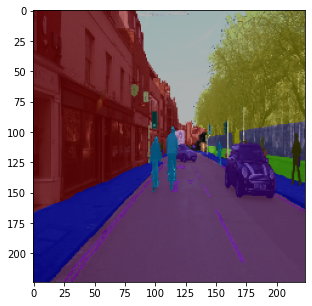

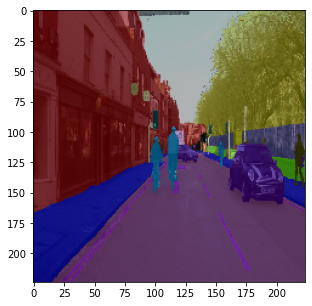

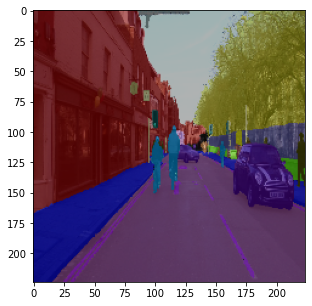

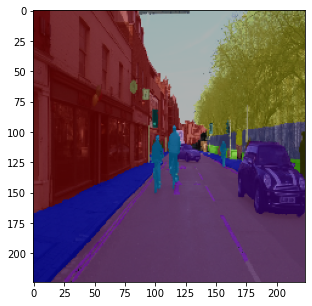

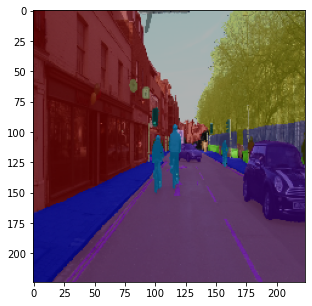

In [13]:
n_images_to_show = 5

for i in range(n_images_to_show):
    
    # Get the next image from iterator
    fig,ax = plt.subplots(1,figsize=(5,5))
    frame = frame_batches.next().numpy().astype(np.uint8)
    mask = mask_batches.next().numpy().astype(np.uint8)
    ax.imshow(frame)
    ax.imshow(mask,alpha = 0.6)

### Creating folder structure common for Computer Vision problems

In [14]:
DATA_PATH = 'data/CamSeq01/'

# Create folders to hold images and masks

folders = ['train_frames/train', 'train_masks/train', 'val_frames/val', 'val_masks/val']


for folder in folders:
    try:
        os.makedirs(DATA_PATH + folder)
    except Exception as e: print(e)

### Saving frames and masks to correct directories

In [15]:
def generate_image_folder_structure(frames, masks, frames_list, masks_list):
    '''Function to save images in the appropriate folder directories 
        Inputs: 
            frames - frame tensor dataset
            masks - mask tensor dataset
            frames_list - frame file paths
            masks_list - mask file paths
    '''
    #Create iterators for frames and masks
    frame_batches = tf.compat.v1.data.make_one_shot_iterator(frames)  # outside of TF Eager, we would use make_one_shot_iterator
    mask_batches = tf.compat.v1.data.make_one_shot_iterator(masks)
    
    #Iterate over the train images while saving the frames and masks in appropriate folders
    dir_name='train'
    for file in zip(frames_list[:-round(0.2*len(frames_list))],masks_list[:-round(0.2*len(masks_list))]):
        
        
        #Convert tensors to numpy arrays
        frame = frame_batches.next().numpy().astype(np.uint8)
        mask = mask_batches.next().numpy().astype(np.uint8)
        
        #Convert numpy arrays to images
        frame = Image.fromarray(frame)
        mask = Image.fromarray(mask)
        
        #Save frames and masks to correct directories
        frame.save(DATA_PATH+'{}_frames/{}'.format(dir_name,dir_name)+'/'+file[0])
        mask.save(DATA_PATH+'{}_masks/{}'.format(dir_name,dir_name)+'/'+file[1])
    
    #Iterate over the val images while saving the frames and masks in appropriate folders
    dir_name='val'
    for file in zip(frames_list[-round(0.2*len(frames_list)):],masks_list[-round(0.2*len(masks_list)):]):
        
        
        #Convert tensors to numpy arrays
        frame = frame_batches.next().numpy().astype(np.uint8)
        mask = mask_batches.next().numpy().astype(np.uint8)
        
        #Convert numpy arrays to images
        frame = Image.fromarray(frame)
        mask = Image.fromarray(mask)
        
        #Save frames and masks to correct directories
        frame.save(DATA_PATH+'{}_frames/{}'.format(dir_name,dir_name)+'/'+file[0])
        mask.save(DATA_PATH+'{}_masks/{}'.format(dir_name,dir_name)+'/'+file[1])
    
    print("Saved {} frames to directory {}".format(len(frames_list),DATA_PATH))
    print("Saved {} masks to directory {}".format(len(masks_list),DATA_PATH))
    
generate_image_folder_structure(frame_tensors, masks_tensors, frames_list, masks_list)

#generate_image_folder_structure(train_frames, train_masks, val_files, 'val')

Saved 101 frames to directory data/CamSeq01/
Saved 101 masks to directory data/CamSeq01/


## Extract Target Class definitions

### Function to parse the file "label_colors.txt" which contains the class definitions

In [16]:
def parse_code(l):
    '''Function to parse lines in a text file, returns separated elements (label codes and names in this case)
    '''
    if len(l.strip().split("\t")) == 2:
        a, b = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), b
    else:
        a, b, c = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), c

### Parse and extract label names and codes

In [17]:
label_codes, label_names = zip(*[parse_code(l) for l in open(img_dir+"label_colors.txt")])
label_codes, label_names = list(label_codes), list(label_names)
label_codes[:5], label_names[:5]

([(64, 128, 64), (192, 0, 128), (0, 128, 192), (0, 128, 64), (128, 0, 0)],
 ['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building'])

In [18]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

In [19]:
name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

### Define functions for one hot encoding rgb labels, and decoding encoded predictions

In [20]:
def rgb_to_onehot(rgb_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image


def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

# Creating custom Image data generators

### Defining data generators

In [21]:
# Normalizing only frame images, since masks contain label info
data_gen_args = dict(rescale=1./255)
mask_gen_args = dict()

train_frames_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**mask_gen_args)
val_frames_datagen = ImageDataGenerator(**data_gen_args)
val_masks_datagen = ImageDataGenerator(**mask_gen_args)

# Seed defined for aligning images and their masks
seed = 1

### Custom image data generators for creating batches of frames and masks

In [22]:
def TrainAugmentGenerator(seed = 1, batch_size = 5):
    '''Train Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''
    train_image_generator = train_frames_datagen.flow_from_directory(
    DATA_PATH + 'train_frames/',
    batch_size = batch_size, seed = seed, target_size = (224, 224))

    train_mask_generator = train_masks_datagen.flow_from_directory(
    DATA_PATH + 'train_masks/',
    batch_size = batch_size, seed = seed, target_size = (224, 224))

    while True:
        X1i = train_image_generator.next()
        X2i = train_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

def ValAugmentGenerator(seed = 1, batch_size = 5):
    '''Validation Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''
    val_image_generator = val_frames_datagen.flow_from_directory(
    DATA_PATH + 'val_frames/',
    batch_size = batch_size, seed = seed, target_size = (224, 224))


    val_mask_generator = val_masks_datagen.flow_from_directory(
    DATA_PATH + 'val_masks/',
    batch_size = batch_size, seed = seed, target_size = (224, 224))


    while True:
        X1i = val_image_generator.next()
        X2i = val_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)
        


In [23]:
from tqdm import tqdm

In [24]:
from tqdm import tqdm_gui

In [25]:
def initial_block(inp):
    inp1 = inp
    conv = Conv2D(filters=13, kernel_size=3, strides=2,
                  padding='same', kernel_initializer='he_normal')(inp)
    pool = MaxPool2D(2)(inp1)
    concat = concatenate([conv, pool])
    return concat


def encoder_bottleneck(inp, filters, name, dilation_rate=2, downsample=False, dilated=False, asymmetric=False, drop_rate=0.1):
    reduce = filters // 4
    down = inp
    kernel_stride = 1

    # Downsample
    if downsample:
        kernel_stride = 2
        pad_activations = filters - inp.shape.as_list()[-1]
        down = MaxPool2D(2)(down)
        down = Permute(dims=(1, 3, 2))(down)
        down = ZeroPadding2D(padding=((0, 0), (0, pad_activations)))(down)
        down = Permute(dims=(1, 3, 2))(down)

    # 1*1 Reduce
    x = Conv2D(filters=reduce, kernel_size=kernel_stride, strides=kernel_stride, padding='same',
               use_bias=False, kernel_initializer='he_normal', name=f'{name}_reduce')(inp)
    x = BatchNormalization(momentum=0.1)(x)
    x = PReLU(shared_axes=[1, 2])(x)

    # Conv
    if not dilated and not asymmetric:
        x = Conv2D(filters=reduce, kernel_size=3, padding='same',
                   kernel_initializer='he_normal', name=f'{name}_conv_reg')(x)
    elif dilated:
        x = Conv2D(filters=reduce, kernel_size=3, padding='same', dilation_rate=dilation_rate,
                   kernel_initializer='he_normal', name=f'{name}_reduce_dilated')(x)
    elif asymmetric:
        x = Conv2D(filters=reduce, kernel_size=(1, 5), padding='same', use_bias=False,
                   kernel_initializer='he_normal', name=f'{name}_asymmetric')(x)
        x = Conv2D(filters=reduce, kernel_size=(5, 1), padding='same',
                   kernel_initializer='he_normal', name=name)(x)
    x = BatchNormalization(momentum=0.1)(x)
    x = PReLU(shared_axes=[1, 2])(x)

    # 1*1 Expand
    x = Conv2D(filters=filters, kernel_size=1, padding='same', use_bias=False,
               kernel_initializer='he_normal', name=f'{name}_expand')(x)
    x = BatchNormalization(momentum=0.1)(x)
    x = SpatialDropout2D(rate=drop_rate)(x)

    concat = Add()([x, down])
    concat = PReLU(shared_axes=[1, 2])(concat)
    return concat


def decoder_bottleneck(inp, filters, name, upsample=False):
    reduce = filters // 4
    up = inp

    # Upsample
    if upsample:
        up = Conv2D(filters=filters, kernel_size=1, strides=1, padding='same',
                    use_bias=False, kernel_initializer='he_normal', name=f'{name}_upsample')(up)
        up = UpSampling2D(size=2)(up)

    # 1*1 Reduce
    x = Conv2D(filters=reduce, kernel_size=1, strides=1, padding='same',
               use_bias=False, kernel_initializer='he_normal', name=f'{name}_reduce')(inp)
    x = BatchNormalization(momentum=0.1)(x)
    x = PReLU(shared_axes=[1, 2])(x)

    # Conv
    if not upsample:
        x = Conv2D(filters=reduce, kernel_size=3, strides=1, padding='same',
                   kernel_initializer='he_normal', name=f'{name}_conv_reg')(x)
    else:
        x = Conv2DTranspose(filters=reduce, kernel_size=3, strides=2, padding='same',
                            kernel_initializer='he_normal', name=f'{name}_transpose')(x)
    x = BatchNormalization(momentum=0.1)(x)
    x = PReLU(shared_axes=[1, 2])(x)

    # 1*1 Expand
    x = Conv2D(filters=filters, kernel_size=1, strides=1, padding='same',
               use_bias=False, kernel_initializer='he_normal', name=f'{name}_expand')(x)
    x = BatchNormalization(momentum=0.1)(x)

    concat = Add()([x, up])
    concat = ReLU()(concat)

    return concat



In [26]:
def ENet(H=224, W=224, nclasses=32):
    '''
    '''

    print('Loading ENet')
    inp = Input(shape=(H, W, 3))
    enc = initial_block(inp)

    # Bottleneck 1.0
    enc = encoder_bottleneck(enc, 64, name='enc1',
                             downsample=True, drop_rate=0.001)

    enc = encoder_bottleneck(enc, 64, name='enc1.1', drop_rate=0.001)
    enc = encoder_bottleneck(enc, 64, name='enc1.2', drop_rate=0.001)
    enc = encoder_bottleneck(enc, 64, name='enc1.3', drop_rate=0.001)
    enc = encoder_bottleneck(enc, 64, name='enc1.4', drop_rate=0.001)

    # Bottleneck 2.0
    enc = encoder_bottleneck(enc, 128, name='enc2.0', downsample=True)
    enc = encoder_bottleneck(enc, 128, name='enc2.1')
    enc = encoder_bottleneck(enc, 128, name='enc2.2',
                             dilation_rate=2, dilated=True)
    enc = encoder_bottleneck(enc, 128, name='enc2.3', asymmetric=True)
    enc = encoder_bottleneck(enc, 128, name='enc2.4',
                             dilation_rate=4, dilated=True)
    enc = encoder_bottleneck(enc, 128, name='enc2.5')
    enc = encoder_bottleneck(enc, 128, name='enc2.6',
                             dilation_rate=8, dilated=True)
    enc = encoder_bottleneck(enc, 128, name='enc2.7', asymmetric=True)
    enc = encoder_bottleneck(enc, 128, name='enc2.8',
                             dilation_rate=16, dilated=True)

    # Bottleneck 3.0
    enc = encoder_bottleneck(enc, 128, name='enc3.0')
    enc = encoder_bottleneck(enc, 128, name='enc3.1',
                             dilation_rate=2, dilated=True)
    enc = encoder_bottleneck(enc, 128, name='enc3.2', asymmetric=True)
    enc = encoder_bottleneck(enc, 128, name='enc3.3',
                             dilation_rate=4, dilated=True)
    enc = encoder_bottleneck(enc, 128, name='enc3.4')
    enc = encoder_bottleneck(enc, 128, name='enc3.5',
                             dilation_rate=8, dilated=True)
    enc = encoder_bottleneck(enc, 128, name='enc3.6', asymmetric=True)
    enc = encoder_bottleneck(enc, 128, name='enc3.7',
                             dilation_rate=16, dilated=True)

    # Bottleneck 4.0
    dec = decoder_bottleneck(enc, 64, name='dec4.0', upsample=True)
    dec = decoder_bottleneck(dec, 64, name='dec4.1')
    dec = decoder_bottleneck(dec, 64, name='dec4.2')

    # Bottleneck 5.0
    dec = decoder_bottleneck(dec, 16, name='dec5.0', upsample=True)
    dec = decoder_bottleneck(dec, 16, name='dec5.1')

    dec = Conv2DTranspose(filters=nclasses, kernel_size=2, strides=2,
                          padding='same', kernel_initializer='he_normal', name='fullconv')(dec)
    dec = Activation('softmax')(dec)

    model = Model(inputs=inp, outputs=dec, name='Enet')
    
    return model

In [27]:
model = ENet()
model.summary()

Loading ENet
Model: "Enet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 13) 364         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 112, 112, 16) 0           conv2d[0][0]                     
                                                                 max_pooling2d[0][

## Defining dice co-efficients for model performance

In [28]:

def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2,3))
    den = num + alpha*K.sum(p0*g1,(0,1,2,3)) + beta*K.sum(p1*g0,(0,1,2,3))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T


def tversky(y_true, y_pred, smooth=1):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)



def focal_tversky_loss_r(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [29]:
@tf.function()
def dice_coef(y_true, y_pred):
    mask =  tf.equal(y_true, 255)
    mask = tf.logical_not(mask)
    y_true = tf.boolean_mask(y_true, mask)
    y_pred = tf.boolean_mask(y_pred, mask)
    
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

In [30]:
smooth = 1.

In [31]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=[dice_coef,'accuracy'])


In [32]:
# tb = TensorBoard(log_dir='logs', write_graph=True)
# mc = ModelCheckpoint(mode='max', filepath='camvid_model_vgg16_segnet_checkpoint.h5', monitor='accuracy', save_best_only='True', save_weights_only='True', verbose=1)
# # es = EarlyStopping(mode='min', monitor='val_loss', patience=4, verbose=1)
# callbacks = [mc]

## Train and save the DEEPLABV3 model

In [33]:
batch_size = 5
steps_per_epoch = np.ceil(float(len(frames_list) - round(0.2*len(frames_list))) / float(batch_size))
steps_per_epoch

17.0

In [34]:
validation_steps = (float((round(0.2*len(frames_list)))) / float(batch_size))
validation_steps

4.0

In [35]:
num_epochs = 35

In [36]:
# Train model

batch_size = 5
result = model.fit_generator(TrainAugmentGenerator(), steps_per_epoch=steps_per_epoch ,
                validation_data = ValAugmentGenerator(), 
                validation_steps = validation_steps, epochs=num_epochs, verbose= 1)

Found 81 images belonging to 1 classes.
Found 81 images belonging to 1 classes.
Epoch 1/35
17/17 [==============================] - ETA: 0s - loss: 3.5396 - dice_coef: 0.0097 - accuracy: 0.1090Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.
17/17 [==============================] - 23s 1s/step - loss: 3.5396 - dice_coef: 0.0097 - accuracy: 0.1090 - val_loss: 2.7332 - val_dice_coef: 0.0751 - val_accuracy: 0.1923
Epoch 2/35
17/17 [==============================] - 21s 1s/step - loss: 2.1693 - dice_coef: 0.2448 - accuracy: 0.3609 - val_loss: 1.8715 - val_dice_coef: 0.3991 - val_accuracy: 0.4887
Epoch 3/35
17/17 [==============================] - 20s 1s/step - loss: 1.4390 - dice_coef: 0.6263 - accuracy: 0.6204 - val_loss: 1.4177 - val_dice_coef: 0.6635 - val_accuracy: 0.6186
Epoch 4/35
17/17 [==============================] - 20s 1s/step - loss: 1.0733 - dice_coef: 0.7586 - accuracy: 0.7104 - val_loss: 1.1366 - val_dice_coef: 0.7078 - val_accuracy: 0.7056
Ep

# Model Evaluation

### Model evaluation historical plots

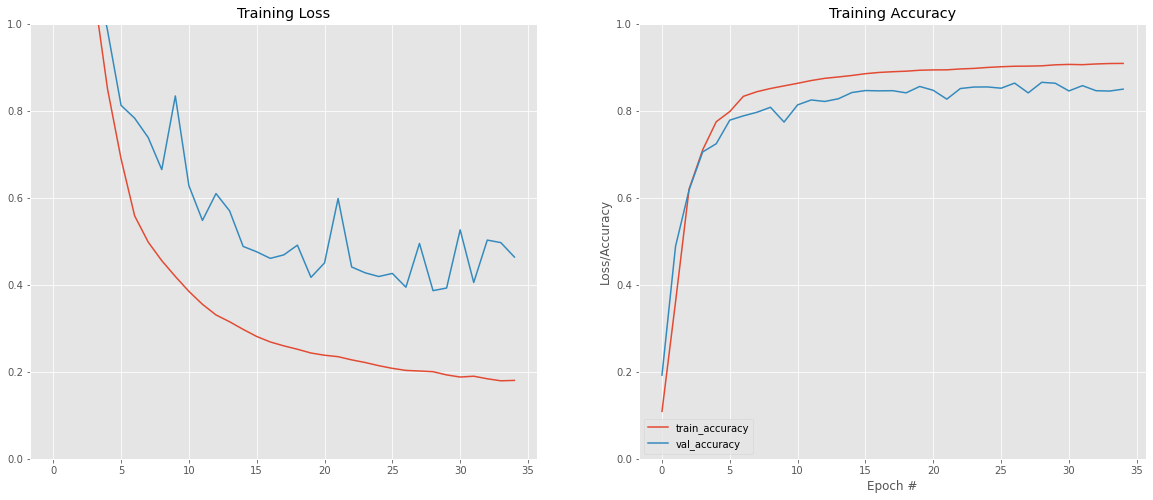

In [37]:
# Get actual number of epochs model was trained for
N = len(result.history['loss'])

#Plot the model evaluation history
plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.title("Training Loss")
plt.plot(np.arange(0, N), result.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), result.history["val_loss"], label="val_loss")
plt.ylim(0, 1)

fig.add_subplot(1,2,2)
plt.title("Training Accuracy")
plt.plot(np.arange(0, N), result.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), result.history["val_accuracy"], label="val_accuracy")
plt.ylim(0, 1)

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

### Extract and display model frame, prediction and mask batch

In [38]:
training_gen = TrainAugmentGenerator()
testing_gen = ValAugmentGenerator()

In [39]:

batch_img,batch_mask = next(testing_gen)
pred_all= model.predict(batch_img)
np.shape(pred_all)


Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.


(5, 224, 224, 32)

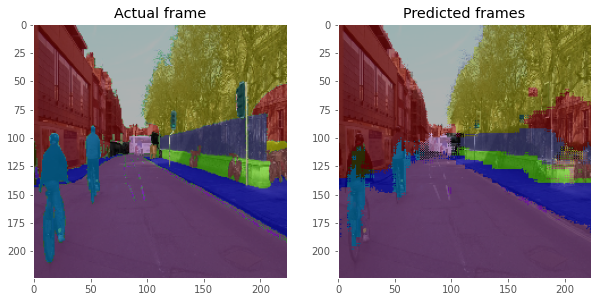

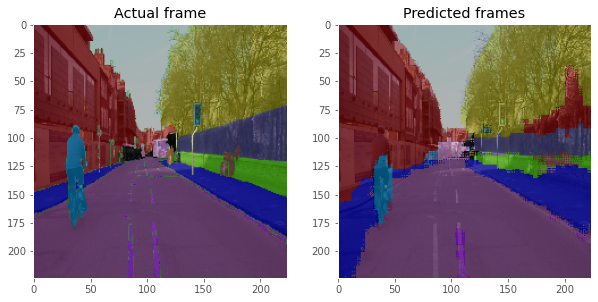

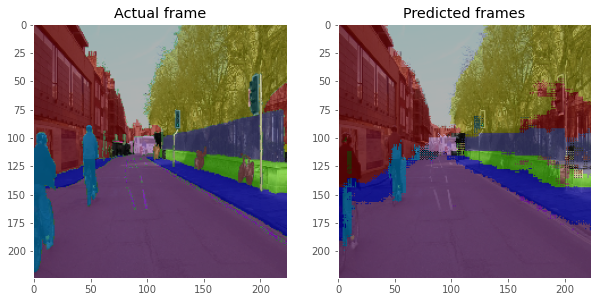

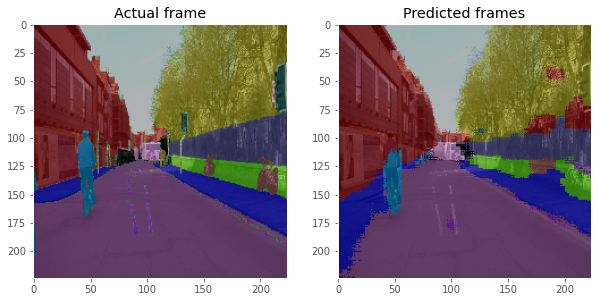

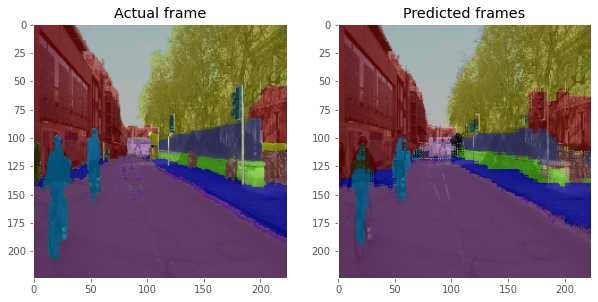

In [40]:
for i in range(0,np.shape(pred_all)[0]):
    
    fig,ax = plt.subplots(1,2,figsize=(10,8))
    
    ax[0].imshow(batch_img[i])
    ax[0].title.set_text('Actual frame')
    ax[0].grid(b=None)
    ax[0].imshow(onehot_to_rgb(batch_mask[i],id2code),alpha = 0.6)
    
    ax[1].set_title('Predicted frames')
    ax[1].imshow(batch_img[i])
    ax[1].imshow(onehot_to_rgb(pred_all[i],id2code),alpha = 0.6)
    ax[1].grid(b=None)
    plt.show()

In [41]:
batch_img,batch_mask = next(training_gen)
pred_all= model.predict(batch_img)
np.shape(pred_all)

Found 81 images belonging to 1 classes.
Found 81 images belonging to 1 classes.


(5, 224, 224, 32)

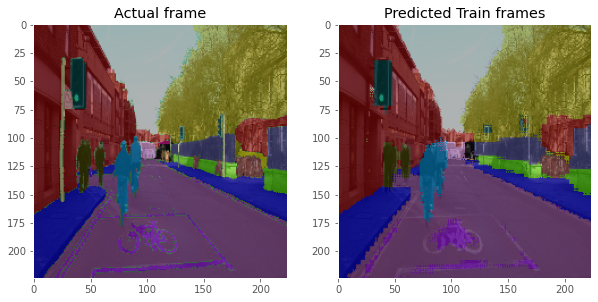

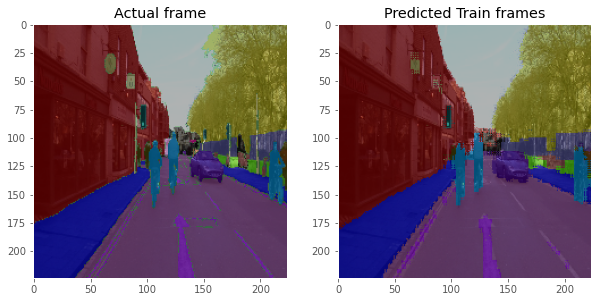

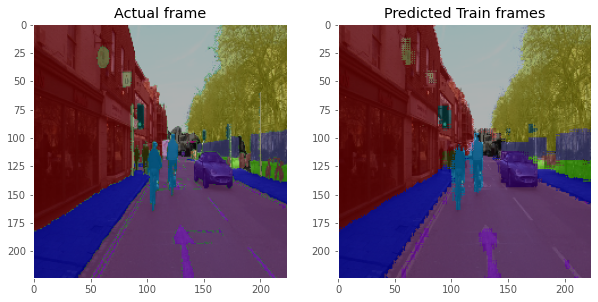

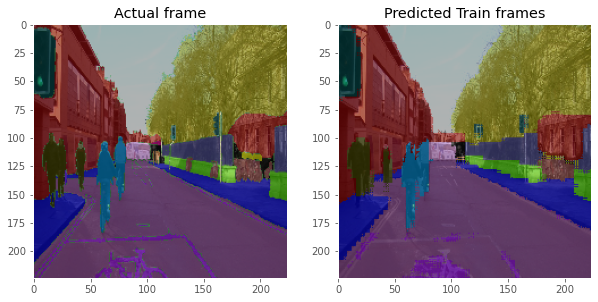

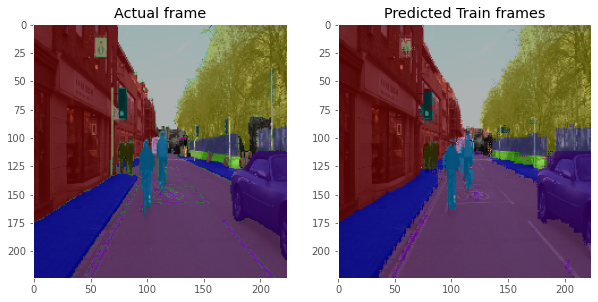

In [42]:
for i in range(0,np.shape(pred_all)[0]):
    
    fig,ax = plt.subplots(1,2,figsize=(10,8))
    
    ax[0].imshow(batch_img[i])
    ax[0].title.set_text('Actual frame')
    ax[0].grid(b=None)
    ax[0].imshow(onehot_to_rgb(batch_mask[i],id2code),alpha = 0.6)
    
    ax[1].set_title('Predicted Train frames')
    ax[1].imshow(batch_img[i])
    ax[1].imshow(onehot_to_rgb(pred_all[i],id2code),alpha = 0.6)
    ax[1].grid(b=None)
    plt.show()

In [43]:
!rm -rf ./*

with albummentation image mask augumentation  on training up to 150 epochs model can be improved very much